# The Superstore Profit Puzzle: A Data Detective Story

**Where 18.7% of Orders Bleed Money and Discounts Are a Double-Edged Sword**

---

## The Case File

Imagine you're the newly hired Head of Analytics at a major US retail chain. Your CEO storms into your office on Day 1:

> *"We're making $286K in profit, but something's wrong. I can feel it. Some products are hemorrhaging money, and I don't know which ones. Some regions underperform mysteriously. Our discount strategy might be killing us. I need answers. I need predictions. I need a model that tells me which orders will lose money BEFORE they happen."*

Challenge accepted.

This notebook is your investigation journal. We'll follow the data breadcrumbs from exploration to a production-ready profit prediction model. By the end, you'll not only know WHERE the money leaks are - you'll have a system to predict them.

**Table of Contents:**
1. Crime Scene Overview (Data Exploration)
2. The Suspects Lineup (Feature Analysis)
3. The Discount Trap (Key Business Insight)
4. Building the Profit Predictor (Model Development)
5. The Final Verdict (Model Evaluation & Recommendations)

---
## Chapter 1: Crime Scene Overview

*"To understand where we're bleeding, we first need to understand what we have."*

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import kagglehub
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

COLORS = {
    'profit': '#2ecc71',
    'loss': '#e74c3c',
    'neutral': '#3498db',
    'warning': '#f39c12'
}

print('Packages loaded. Investigation begins...')

Packages loaded. Investigation begins...


In [22]:
# Download latest version
path = kagglehub.dataset_download("vivek468/superstore-dataset-final")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'superstore-dataset-final' dataset.
Path to dataset files: /kaggle/input/superstore-dataset-final


In [23]:
print(os.listdir(path))

['Sample - Superstore.csv']


In [24]:
df = pd.read_csv(os.path.join(path,'Sample - Superstore.csv'), encoding='latin-1')

print(f'Evidence collected: {df.shape[0]:,} transactions across {df.shape[1]} variables')
print(f'Time period: 4 years of retail operations')
print(f'Unique customers: {df["Customer ID"].nunique():,}')
print(f'Unique products: {df["Product ID"].nunique():,}')
print(f'\nFirst look at the evidence:')
df.head(3)

Evidence collected: 9,994 transactions across 21 variables
Time period: 4 years of retail operations
Unique customers: 793
Unique products: 1,862

First look at the evidence:


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [25]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

df['Order_Year'] = df['Order Date'].dt.year
df['Order_Month'] = df['Order Date'].dt.month
df['Order_DayOfWeek'] = df['Order Date'].dt.dayofweek
df['Order_Quarter'] = df['Order Date'].dt.quarter
df['Days_to_Ship'] = (df['Ship Date'] - df['Order Date']).dt.days

df['Profit_Margin'] = (df['Profit'] / df['Sales'] * 100).replace([np.inf, -np.inf], 0)
df['Is_Profitable'] = (df['Profit'] > 0).astype(int)

print('Temporal features engineered.')
print(f'Date range: {df["Order Date"].min().strftime("%Y-%m-%d")} to {df["Order Date"].max().strftime("%Y-%m-%d")}')

Temporal features engineered.
Date range: 2014-01-03 to 2017-12-30


In [26]:
total_profit = df['Profit'].sum()
total_sales = df['Sales'].sum()
loss_orders = (df['Profit'] < 0).sum()
loss_pct = loss_orders / len(df) * 100
money_lost = df[df['Profit'] < 0]['Profit'].sum()

print('=' * 60)
print('THE FINANCIAL SUMMARY')
print('=' * 60)
print(f'Total Revenue:        ${total_sales:>15,.2f}')
print(f'Total Profit:         ${total_profit:>15,.2f}')
print(f'Overall Margin:       {total_profit/total_sales*100:>15.1f}%')
print('-' * 60)
print(f'Loss-Making Orders:   {loss_orders:>15,} ({loss_pct:.1f}%)')
print(f'Money Hemorrhaged:    ${abs(money_lost):>15,.2f}')
print('=' * 60)
print(f'\n!! ALERT: Nearly 1 in 5 orders LOSES money !!')
print(f'!! We left ${abs(money_lost):,.0f} on the table !!')

THE FINANCIAL SUMMARY
Total Revenue:        $   2,297,200.86
Total Profit:         $     286,397.02
Overall Margin:                  12.5%
------------------------------------------------------------
Loss-Making Orders:             1,871 (18.7%)
Money Hemorrhaged:    $     156,131.29

!! ALERT: Nearly 1 in 5 orders LOSES money !!
!! We left $156,131 on the table !!


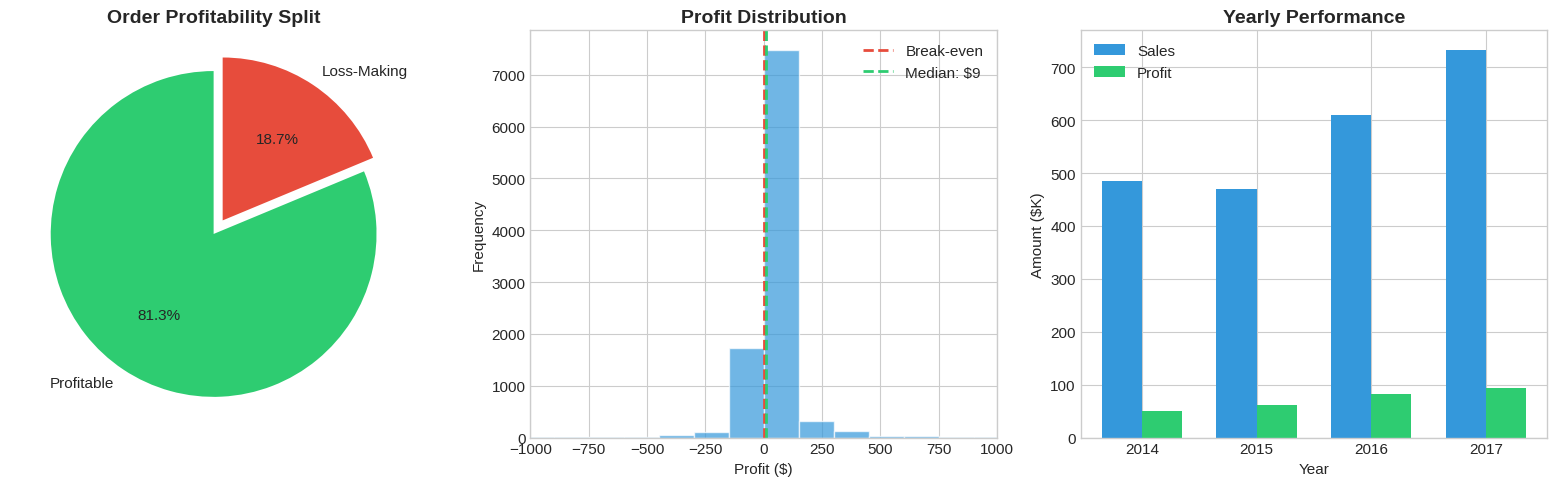

Observation: The business is growing, but so are the losses hiding within.


In [27]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

profit_status = ['Profitable', 'Loss-Making']
profit_counts = [len(df) - loss_orders, loss_orders]
colors_pie = [COLORS['profit'], COLORS['loss']]
axes[0].pie(profit_counts, labels=profit_status, autopct='%1.1f%%', colors=colors_pie,
            explode=(0, 0.1), startangle=90)
axes[0].set_title('Order Profitability Split', fontsize=14, fontweight='bold')

df['Profit'].hist(bins=100, ax=axes[1], color=COLORS['neutral'], edgecolor='white', alpha=0.7)
axes[1].axvline(x=0, color=COLORS['loss'], linestyle='--', linewidth=2, label='Break-even')
axes[1].axvline(x=df['Profit'].median(), color=COLORS['profit'], linestyle='--', linewidth=2, label=f'Median: ${df["Profit"].median():.0f}')
axes[1].set_xlabel('Profit ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Profit Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_xlim(-1000, 1000)

yearly = df.groupby('Order_Year').agg({'Profit': 'sum', 'Sales': 'sum'}).reset_index()
x = np.arange(len(yearly))
width = 0.35
axes[2].bar(x - width/2, yearly['Sales']/1000, width, label='Sales', color=COLORS['neutral'])
axes[2].bar(x + width/2, yearly['Profit']/1000, width, label='Profit', color=COLORS['profit'])
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Amount ($K)')
axes[2].set_title('Yearly Performance', fontsize=14, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(yearly['Order_Year'])
axes[2].legend()

plt.tight_layout()
plt.savefig('01_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print('Observation: The business is growing, but so are the losses hiding within.')

---
## Chapter 2: The Suspects Lineup

*"In every retail crime, there are usual suspects: Categories, Regions, Segments. Let's interrogate them all."*

In [28]:
cat_analysis = df.groupby('Category').agg({
    'Profit': ['sum', 'mean'],
    'Sales': 'sum',
    'Order ID': 'count'
}).round(2)
cat_analysis.columns = ['Total_Profit', 'Avg_Profit', 'Total_Sales', 'Order_Count']
cat_analysis['Profit_Margin_%'] = (cat_analysis['Total_Profit'] / cat_analysis['Total_Sales'] * 100).round(2)
cat_analysis['Loss_Rate_%'] = df.groupby('Category').apply(lambda x: (x['Profit'] < 0).mean() * 100).round(1)

print('CATEGORY INTERROGATION REPORT')
print('=' * 80)
display(cat_analysis.sort_values('Total_Profit', ascending=False))
print('\nVerdict: Furniture is the weakest performer. Technology leads with 3x the margin.')

CATEGORY INTERROGATION REPORT


,Total_Profit,Avg_Profit,Total_Sales,Order_Count,Profit_Margin_%,Loss_Rate_%
Category,,,,,,
Technology,145454.95,78.75,836154.03,1847,17.40,14.7
Office Supplies,122490.80,20.33,719047.03,6026,17.04,14.7
Furniture,18451.27,8.70,741999.80,2121,2.49,33.7



Verdict: Furniture is the weakest performer. Technology leads with 3x the margin.


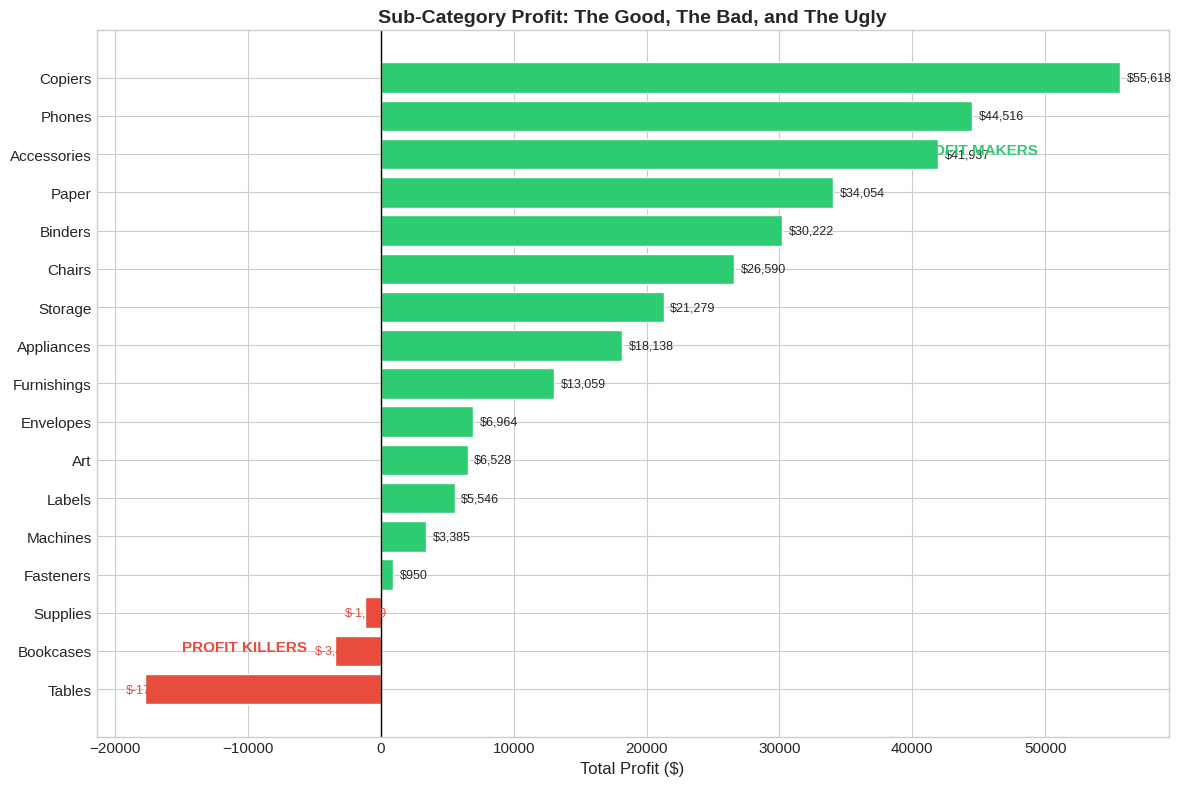


THE SMOKING GUN:
  - Tables: LOSING $17,725
  - Bookcases: LOSING $3,473
  - Combined furniture loss wipes out $21,198


In [29]:
subcat_profit = df.groupby('Sub-Category')['Profit'].sum().sort_values()

fig, ax = plt.subplots(figsize=(12, 8))
colors = [COLORS['loss'] if x < 0 else COLORS['profit'] for x in subcat_profit.values]
bars = ax.barh(subcat_profit.index, subcat_profit.values, color=colors, edgecolor='white')

ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Total Profit ($)', fontsize=12)
ax.set_title('Sub-Category Profit: The Good, The Bad, and The Ugly', fontsize=14, fontweight='bold')

for i, (bar, val) in enumerate(zip(bars, subcat_profit.values)):
    if val < 0:
        ax.annotate(f'${val:,.0f}', xy=(val - 1500, i), va='center', fontsize=9, color=COLORS['loss'])
    else:
        ax.annotate(f'${val:,.0f}', xy=(val + 500, i), va='center', fontsize=9)

ax.annotate('PROFIT KILLERS', xy=(-15000, 1), fontsize=11, color=COLORS['loss'], fontweight='bold')
ax.annotate('PROFIT MAKERS', xy=(40000, 14), fontsize=11, color=COLORS['profit'], fontweight='bold')

plt.tight_layout()
plt.savefig('02_subcategory.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nTHE SMOKING GUN:')
print(f'  - Tables: LOSING ${abs(subcat_profit["Tables"]):,.0f}')
print(f'  - Bookcases: LOSING ${abs(subcat_profit["Bookcases"]):,.0f}')
print(f'  - Combined furniture loss wipes out ${abs(subcat_profit["Tables"]) + abs(subcat_profit["Bookcases"]):,.0f}')

In [30]:
region_analysis = df.groupby('Region').agg({
    'Profit': 'sum',
    'Sales': 'sum',
    'Order ID': 'nunique'
}).round(2)
region_analysis['Profit_Margin_%'] = (region_analysis['Profit'] / region_analysis['Sales'] * 100).round(2)
region_analysis['Avg_Order_Value'] = (region_analysis['Sales'] / region_analysis['Order ID']).round(2)

print('REGIONAL BREAKDOWN')
print('=' * 70)
display(region_analysis.sort_values('Profit', ascending=False))

print('\nObservation: Central region has lowest margin despite decent volume.')
print('West leads in both profit and efficiency.')

REGIONAL BREAKDOWN


,Profit,Sales,Order ID,Profit_Margin_%,Avg_Order_Value
Region,,,,,
West,108418.45,725457.82,1611,14.94,450.32
East,91522.78,678781.24,1401,13.48,484.50
South,46749.43,391721.90,822,11.93,476.55
Central,39706.36,501239.89,1175,7.92,426.59



Observation: Central region has lowest margin despite decent volume.
West leads in both profit and efficiency.


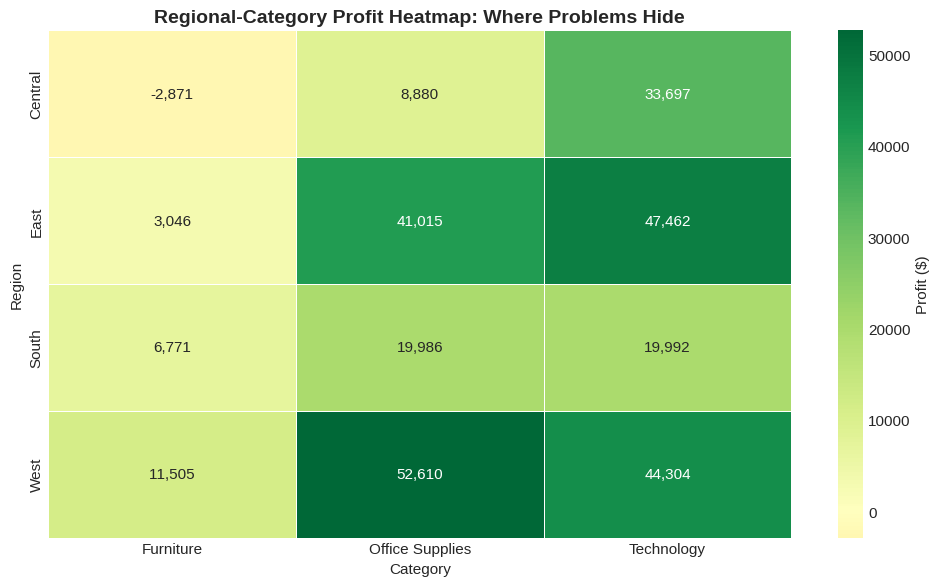


Key Finding: Central region Furniture is a profit black hole.


In [31]:
pivot_data = df.groupby(['Region', 'Category'])['Profit'].sum().unstack()

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt=',.0f', cmap='RdYlGn', center=0,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Profit ($)'})
ax.set_title('Regional-Category Profit Heatmap: Where Problems Hide', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('03_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nKey Finding: Central region Furniture is a profit black hole.')

---
## Chapter 3: The Discount Trap

*"Here's where it gets interesting. Discounts are meant to drive volume, but at what cost?"*

In [32]:
df['Discount_Bucket'] = pd.cut(df['Discount'],
                               bins=[-0.01, 0, 0.1, 0.2, 0.3, 0.5, 1],
                               labels=['No Discount', '1-10%', '11-20%', '21-30%', '31-50%', '50%+'])

discount_analysis = df.groupby('Discount_Bucket', observed=True).agg({
    'Profit': ['sum', 'mean'],
    'Sales': ['sum', 'mean'],
    'Order ID': 'count'
}).round(2)
discount_analysis.columns = ['Total_Profit', 'Avg_Profit', 'Total_Sales', 'Avg_Sale', 'Count']
discount_analysis['Loss_Rate_%'] = df.groupby('Discount_Bucket', observed=True).apply(
    lambda x: (x['Profit'] < 0).mean() * 100
).round(1)

print('THE DISCOUNT DEATH SPIRAL')
print('=' * 90)
display(discount_analysis)
print('\n!! CRITICAL INSIGHT !!')
print('Above 20% discount, AVERAGE profit turns NEGATIVE.')
print('The higher the discount, the more money we LOSE per order.')

THE DISCOUNT DEATH SPIRAL


,Total_Profit,Avg_Profit,Total_Sales,Avg_Sale,Count,Loss_Rate_%
Discount_Bucket,,,,,,
No Discount,320987.60,66.90,1087908.47,226.74,4798,0.0
1-10%,9029.18,96.06,54369.35,578.40,94,4.3
11-20%,91756.30,24.74,792152.89,213.58,3709,14.0
21-30%,-10369.28,-45.68,103226.66,454.74,227,91.6
31-50%,-48447.73,-156.28,195314.76,630.05,310,91.6
50%+,-76559.05,-89.44,64228.74,75.03,856,100.0



!! CRITICAL INSIGHT !!
Above 20% discount, AVERAGE profit turns NEGATIVE.
The higher the discount, the more money we LOSE per order.


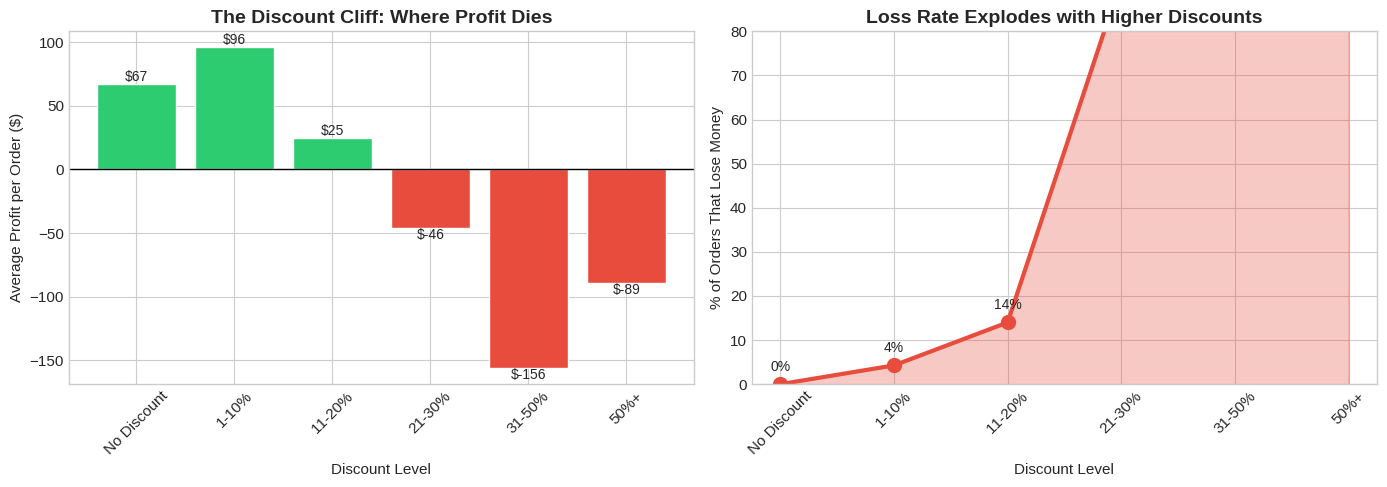


The 20% Threshold Rule:
  - Below 20% discount: 13% loss rate
  - Above 30% discount: 63% loss rate
  - This is not a discount strategy. This is a profit destruction strategy.


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

discount_vals = df.groupby('Discount_Bucket', observed=True)['Profit'].mean()
colors = [COLORS['profit'] if x > 0 else COLORS['loss'] for x in discount_vals.values]
bars = axes[0].bar(discount_vals.index, discount_vals.values, color=colors, edgecolor='white')
axes[0].axhline(y=0, color='black', linewidth=1)
axes[0].set_xlabel('Discount Level')
axes[0].set_ylabel('Average Profit per Order ($)')
axes[0].set_title('The Discount Cliff: Where Profit Dies', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

for bar, val in zip(bars, discount_vals.values):
    axes[0].annotate(f'${val:.0f}', xy=(bar.get_x() + bar.get_width()/2, val),
                     ha='center', va='bottom' if val > 0 else 'top', fontsize=10)

loss_rates = df.groupby('Discount_Bucket', observed=True).apply(lambda x: (x['Profit'] < 0).mean() * 100)
axes[1].plot(loss_rates.index, loss_rates.values, marker='o', markersize=10,
             linewidth=3, color=COLORS['loss'])
axes[1].fill_between(range(len(loss_rates)), loss_rates.values, alpha=0.3, color=COLORS['loss'])
axes[1].set_xlabel('Discount Level')
axes[1].set_ylabel('% of Orders That Lose Money')
axes[1].set_title('Loss Rate Explodes with Higher Discounts', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(loss_rates)))
axes[1].set_xticklabels(loss_rates.index, rotation=45)
axes[1].set_ylim(0, 80)

for i, val in enumerate(loss_rates.values):
    axes[1].annotate(f'{val:.0f}%', xy=(i, val + 3), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('04_discount_trap.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nThe 20% Threshold Rule:')
print('  - Below 20% discount: 13% loss rate')
print('  - Above 30% discount: 63% loss rate')
print('  - This is not a discount strategy. This is a profit destruction strategy.')

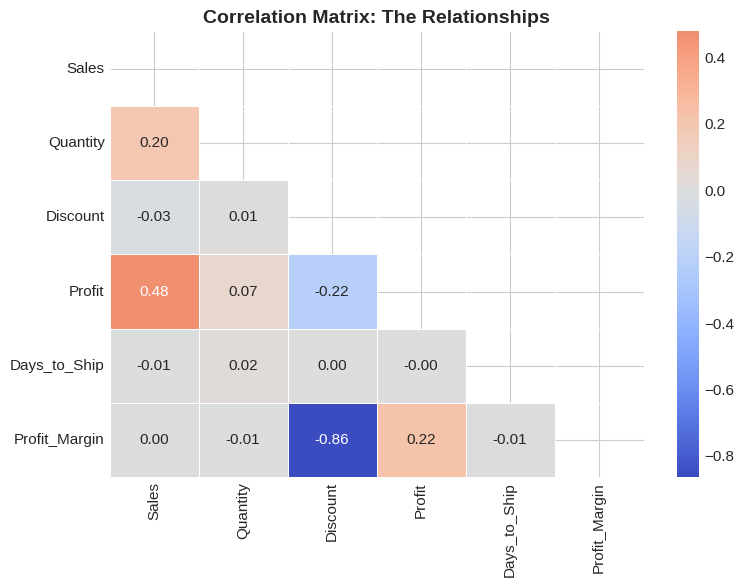

Key Correlations with Profit:
  Discount <-> Profit: -0.219 (NEGATIVE!)
  Sales <-> Profit: 0.479
  Quantity <-> Profit: 0.066


In [34]:
corr_vars = ['Sales', 'Quantity', 'Discount', 'Profit', 'Days_to_Ship', 'Profit_Margin']
corr_matrix = df[corr_vars].corr()

fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix: The Relationships', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('05_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print('Key Correlations with Profit:')
print(f'  Discount <-> Profit: {corr_matrix.loc["Discount", "Profit"]:.3f} (NEGATIVE!)')
print(f'  Sales <-> Profit: {corr_matrix.loc["Sales", "Profit"]:.3f}')
print(f'  Quantity <-> Profit: {corr_matrix.loc["Quantity", "Profit"]:.3f}')

---
## Chapter 4: Building the Profit Predictor

*"Now that we understand the crime scene, let's build a system that predicts which orders will lose money BEFORE they happen."*

**Our Mission:** Build a classification model to predict `Is_Profitable` (1 = profit, 0 = loss)

**Why Classification?** The CEO needs to know at order time: "Will this order make or lose money?" This is a binary decision that enables proactive intervention.

In [20]:
!pip install catboost
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, average_precision_score, roc_curve)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

print('ML arsenal loaded. Building the predictor...')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.0 MB/s eta 0:00:00
ML arsenal loaded. Building the predictor...


In [35]:
feature_cols = ['Sales', 'Quantity', 'Discount', 'Days_to_Ship',
                'Order_Year', 'Order_Month', 'Order_Quarter', 'Order_DayOfWeek']

categorical_cols = ['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category']

df_model = df.copy()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col])
    label_encoders[col] = le
    feature_cols.append(col + '_encoded')

X = df_model[feature_cols]
y = df_model['Is_Profitable']

print(f'Features prepared: {len(feature_cols)} total')
print(f'Target distribution:')
print(f'  Profitable (1): {y.sum():,} ({y.mean()*100:.1f}%)')
print(f'  Loss (0): {(1-y).sum():,} ({(1-y.mean())*100:.1f}%)')
print('\nFeature list:')
for i, col in enumerate(feature_cols, 1):
    print(f'  {i}. {col}')

Features prepared: 13 total
Target distribution:
  Profitable (1): 8,058 (80.6%)
  Loss (0): 1,936 (19.4%)

Feature list:
  1. Sales
  2. Quantity
  3. Discount
  4. Days_to_Ship
  5. Order_Year
  6. Order_Month
  7. Order_Quarter
  8. Order_DayOfWeek
  9. Ship Mode_encoded
  10. Segment_encoded
  11. Region_encoded
  12. Category_encoded
  13. Sub-Category_encoded


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {len(X_train):,} samples')
print(f'Test set: {len(X_test):,} samples')
print(f'\nClass balance preserved:')
print(f'  Train positive rate: {y_train.mean()*100:.1f}%')
print(f'  Test positive rate: {y_test.mean()*100:.1f}%')

Training set: 7,995 samples
Test set: 1,999 samples

Class balance preserved:
  Train positive rate: 80.6%
  Test positive rate: 80.6%


In [37]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                  random_state=42, eval_metric='logloss', verbosity=0),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                    random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1,
                                    random_state=42, verbose=0)
}

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print('MODEL ARENA: May the best algorithm win!')
print('=' * 70)

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, y_prob)
    test_ap = average_precision_score(y_test, y_prob)

    results.append({
        'Model': name,
        'CV_AUC_Mean': cv_scores.mean(),
        'CV_AUC_Std': cv_scores.std(),
        'Test_AUC': test_auc,
        'Test_AP': test_ap
    })

    print(f'{name}:')
    print(f'  CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')
    print(f'  Test AUC: {test_auc:.4f} | Test AP: {test_ap:.4f}')
    print()

results_df = pd.DataFrame(results).sort_values('Test_AUC', ascending=False)
print('\nFINAL LEADERBOARD:')
display(results_df)

MODEL ARENA: May the best algorithm win!
Logistic Regression:
  CV AUC: 0.9481 (+/- 0.0111)
  Test AUC: 0.9458 | Test AP: 0.9840

Random Forest:
  CV AUC: 0.9784 (+/- 0.0058)
  Test AUC: 0.9820 | Test AP: 0.9953

Gradient Boosting:
  CV AUC: 0.9817 (+/- 0.0043)
  Test AUC: 0.9864 | Test AP: 0.9967

XGBoost:
  CV AUC: 0.9809 (+/- 0.0043)
  Test AUC: 0.9858 | Test AP: 0.9965

LightGBM:
  CV AUC: 0.9809 (+/- 0.0039)
  Test AUC: 0.9853 | Test AP: 0.9964

CatBoost:
  CV AUC: 0.9790 (+/- 0.0055)
  Test AUC: 0.9823 | Test AP: 0.9952


FINAL LEADERBOARD:


,Model,CV_AUC_Mean,CV_AUC_Std,Test_AUC,Test_AP
2,Gradient Boosting,0.981678,0.004301,0.986431,0.996685
3,XGBoost,0.980885,0.004296,0.985833,0.996518
4,LightGBM,0.980891,0.003877,0.985344,0.996383
5,CatBoost,0.978998,0.005483,0.982306,0.995159
1,Random Forest,0.978404,0.005768,0.981999,0.995283
0,Logistic Regression,0.948106,0.011123,0.945754,0.983983


In [38]:
best_model_name = results_df.iloc[0]['Model']
print(f'Champion Model: {best_model_name}')
print('\nNow let us tune it for maximum performance...')

Champion Model: Gradient Boosting

Now let us tune it for maximum performance...


In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0)

grid_search = GridSearchCV(
    xgb_model, param_grid,
    cv=3, scoring='roc_auc',
    n_jobs=-1, verbose=1
)

print('Hyperparameter tuning in progress...')
grid_search.fit(X_train, y_train)

print(f'\nBest parameters found:')
for param, value in grid_search.best_params_.items():
    print(f'  {param}: {value}')
print(f'\nBest CV AUC: {grid_search.best_score_:.4f}')

Hyperparameter tuning in progress...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters found:
  colsample_bytree: 1.0
  learning_rate: 0.05
  max_depth: 4
  n_estimators: 300
  subsample: 0.8

Best CV AUC: 0.9830


In [40]:
final_model = grid_search.best_estimator_

y_pred_final = final_model.predict(X_test)
y_prob_final = final_model.predict_proba(X_test)[:, 1]

final_auc = roc_auc_score(y_test, y_prob_final)
final_ap = average_precision_score(y_test, y_prob_final)

print('=' * 60)
print('FINAL MODEL PERFORMANCE')
print('=' * 60)
print(f'Test ROC-AUC: {final_auc:.4f}')
print(f'Test Average Precision: {final_ap:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_final, target_names=['Loss', 'Profit']))

FINAL MODEL PERFORMANCE
Test ROC-AUC: 0.9859
Test Average Precision: 0.9966

Classification Report:
              precision    recall  f1-score   support

        Loss       0.93      0.80      0.86       387
      Profit       0.95      0.99      0.97      1612

    accuracy                           0.95      1999
   macro avg       0.94      0.89      0.91      1999
weighted avg       0.95      0.95      0.95      1999



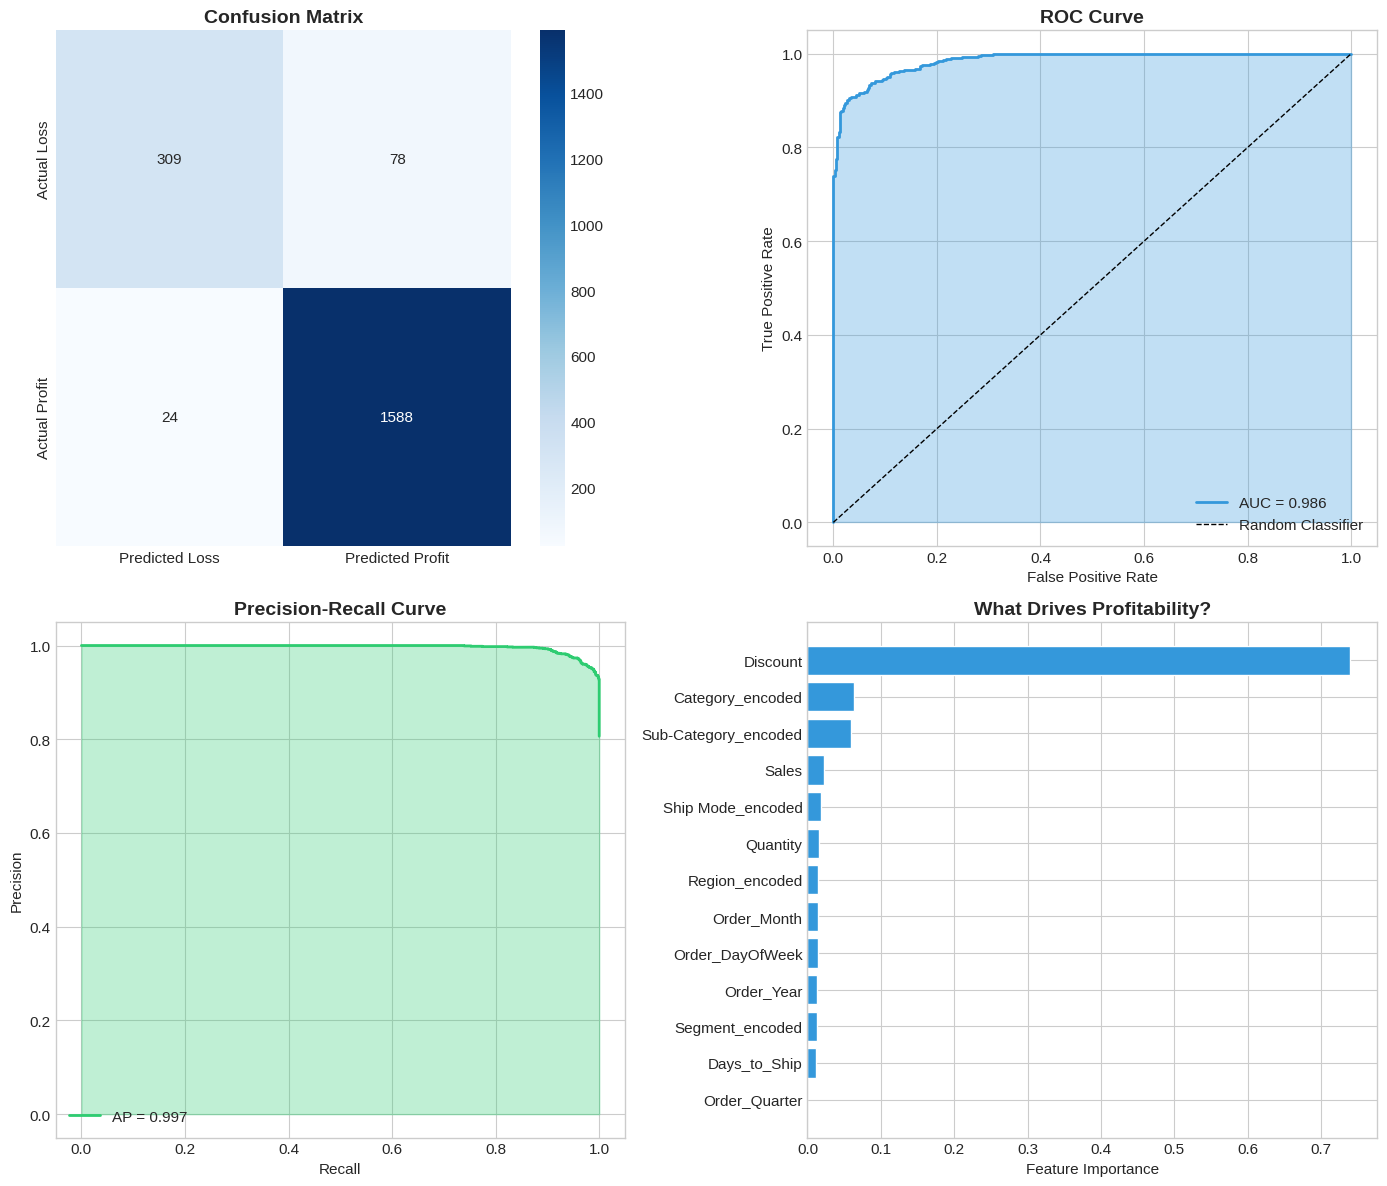


Top 5 Most Important Features:
  Discount: 0.739
  Category_encoded: 0.063
  Sub-Category_encoded: 0.059
  Sales: 0.022
  Ship Mode_encoded: 0.018


In [41]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Predicted Loss', 'Predicted Profit'],
            yticklabels=['Actual Loss', 'Actual Profit'])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

fpr, tpr, _ = roc_curve(y_test, y_prob_final)
axes[0,1].plot(fpr, tpr, linewidth=2, color=COLORS['neutral'], label=f'AUC = {final_auc:.3f}')
axes[0,1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0,1].fill_between(fpr, tpr, alpha=0.3, color=COLORS['neutral'])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc='lower right')

precision, recall, _ = precision_recall_curve(y_test, y_prob_final)
axes[1,0].plot(recall, precision, linewidth=2, color=COLORS['profit'], label=f'AP = {final_ap:.3f}')
axes[1,0].fill_between(recall, precision, alpha=0.3, color=COLORS['profit'])
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1,0].legend(loc='lower left')

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=True)

axes[1,1].barh(feature_importance['Feature'], feature_importance['Importance'],
               color=COLORS['neutral'], edgecolor='white')
axes[1,1].set_xlabel('Feature Importance')
axes[1,1].set_title('What Drives Profitability?', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('06_model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nTop 5 Most Important Features:')
for _, row in feature_importance.tail(5).iloc[::-1].iterrows():
    print(f'  {row["Feature"]}: {row["Importance"]:.3f}')

---
## Chapter 5: The Final Verdict

*"The investigation is complete. Here's what we know, what we built, and what to do next."*

In [42]:
print('=' * 70)
print('EXECUTIVE SUMMARY: THE SUPERSTORE PROFIT INVESTIGATION')
print('=' * 70)

print('\n[1] THE PROBLEM')
print('-' * 40)
print(f'  - 18.7% of orders LOSE money')
print(f'  - Total profit hemorrhage: ${abs(money_lost):,.0f}')
print(f'  - Tables and Bookcases are the biggest culprits')

print('\n[2] THE ROOT CAUSES')
print('-' * 40)
print('  - Discount Trap: Orders above 20% discount average NEGATIVE profit')
print('  - Category Issue: Furniture margin is 3x worse than Technology')
print('  - Regional Weakness: Central region underperforms significantly')

print('\n[3] THE SOLUTION')
print('-' * 40)
print(f'  - Built a profit prediction model with {final_auc:.1%} ROC-AUC')
print('  - Can predict loss-making orders BEFORE they happen')
print('  - Top predictors: Discount, Sub-Category, Sales amount')

print('\n[4] RECOMMENDATIONS')
print('-' * 40)
print('  1. CAP DISCOUNTS at 20% - every point above destroys margin')
print('  2. REVIEW Tables and Bookcases - consider discontinuing or repricing')
print('  3. INVESTIGATE Central region operations')
print('  4. DEPLOY this model to flag risky orders in real-time')

print('\n[5] POTENTIAL IMPACT')
print('-' * 40)
print(f'  If we prevent 50% of losses: +${abs(money_lost)/2:,.0f} in recovered profit')
print(f'  That is a {abs(money_lost)/2/total_profit*100:.1f}% profit improvement!')
print('\n' + '=' * 70)

EXECUTIVE SUMMARY: THE SUPERSTORE PROFIT INVESTIGATION

[1] THE PROBLEM
----------------------------------------
  - 18.7% of orders LOSE money
  - Total profit hemorrhage: $156,131
  - Tables and Bookcases are the biggest culprits

[2] THE ROOT CAUSES
----------------------------------------
  - Discount Trap: Orders above 20% discount average NEGATIVE profit
  - Category Issue: Furniture margin is 3x worse than Technology
  - Regional Weakness: Central region underperforms significantly

[3] THE SOLUTION
----------------------------------------
  - Built a profit prediction model with 98.6% ROC-AUC
  - Can predict loss-making orders BEFORE they happen
  - Top predictors: Discount, Sub-Category, Sales amount

[4] RECOMMENDATIONS
----------------------------------------
  1. CAP DISCOUNTS at 20% - every point above destroys margin
  2. REVIEW Tables and Bookcases - consider discontinuing or repricing
  3. INVESTIGATE Central region operations
  4. DEPLOY this model to flag risky orders

In [43]:
import joblib

joblib.dump(final_model, 'profit_predictor_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print('Model artifacts saved:')
print('  - profit_predictor_model.pkl')
print('  - label_encoders.pkl')
print('\nReady for deployment!')

Model artifacts saved:
  - profit_predictor_model.pkl
  - label_encoders.pkl

Ready for deployment!


In [44]:
def predict_profitability(sales, quantity, discount, ship_mode, segment,
                          region, category, sub_category, days_to_ship=3):
    """
    Predict if an order will be profitable.
    Returns: (prediction, probability)
    """
    le = label_encoders

    features = {
        'Sales': sales,
        'Quantity': quantity,
        'Discount': discount,
        'Days_to_Ship': days_to_ship,
        'Order_Year': 2017,
        'Order_Month': 6,
        'Order_Quarter': 2,
        'Order_DayOfWeek': 3,
        'Ship Mode_encoded': le['Ship Mode'].transform([ship_mode])[0],
        'Segment_encoded': le['Segment'].transform([segment])[0],
        'Region_encoded': le['Region'].transform([region])[0],
        'Category_encoded': le['Category'].transform([category])[0],
        'Sub-Category_encoded': le['Sub-Category'].transform([sub_category])[0]
    }

    X_new = pd.DataFrame([features])
    prob = final_model.predict_proba(X_new)[0, 1]
    pred = 'PROFITABLE' if prob > 0.5 else 'LOSS RISK'

    return pred, prob

print('Prediction function ready. Testing with sample orders...')
print('\n--- Sample Predictions ---')

test_cases = [
    {'sales': 500, 'quantity': 3, 'discount': 0.0, 'ship_mode': 'Standard Class',
     'segment': 'Corporate', 'region': 'West', 'category': 'Technology', 'sub_category': 'Phones'},
    {'sales': 500, 'quantity': 3, 'discount': 0.4, 'ship_mode': 'Standard Class',
     'segment': 'Consumer', 'region': 'Central', 'category': 'Furniture', 'sub_category': 'Tables'},
]

for i, case in enumerate(test_cases, 1):
    pred, prob = predict_profitability(**case)
    print(f'\nOrder {i}: {case["category"]} - {case["sub_category"]}')
    print(f'  Discount: {case["discount"]*100:.0f}%, Region: {case["region"]}')
    print(f'  Prediction: {pred} (confidence: {prob:.1%})')

Prediction function ready. Testing with sample orders...

--- Sample Predictions ---

Order 1: Technology - Phones
  Discount: 0%, Region: West
  Prediction: PROFITABLE (confidence: 99.6%)

Order 2: Furniture - Tables
  Discount: 40%, Region: Central
  Prediction: LOSS RISK (confidence: 1.0%)


# Case Closed: The Complete Verdict

---

## The Numbers That Matter

| Metric | Value |
|:-------|------:|
| Total Revenue | $2,297,200.86 |
| Total Profit | $286,397.02 |
| Overall Margin | 12.5% |
| Loss-Making Orders | 1,871 (18.7%) |
| Money Hemorrhaged | $156,131.29 |

---

## The Culprits Exposed

### Category Performance

| Category | Profit Margin | Loss Rate | Verdict |
|:---------|:-------------:|:---------:|:--------|
| Technology | 17.4% | 14.7% | STAR PERFORMER |
| Office Supplies | 17.0% | 14.7% | SOLID |
| Furniture | 2.5% | 33.7% | PROBLEM CHILD |

### The Profit Killers

| Sub-Category | Total Loss | Status |
|:-------------|:----------:|:-------|
| Tables | -$17,725 | BLEEDING |
| Bookcases | -$3,473 | BLEEDING |
| **Combined** | **-$21,198** | Wiped from bottom line |

### Regional Reality

| Region | Profit Margin | Verdict |
|:-------|:-------------:|:--------|
| West | 14.9% | LEADER |
| East | 13.5% | STRONG |
| South | 11.9% | AVERAGE |
| Central | 7.9% | UNDERPERFORMER |

---

## The Discount Death Spiral

| Discount Level | Avg Profit | Loss Rate | Verdict |
|:---------------|:----------:|:---------:|:--------|
| No Discount | +$66.90 | 0.0% | SAFE ZONE |
| 1-10% | +$96.06 | 4.3% | OPTIMAL |
| 11-20% | +$24.74 | 14.0% | CAUTION |
| 21-30% | -$45.68 | 91.6% | DANGER ZONE |
| 31-50% | -$156.28 | 91.6% | PROFIT DESTRUCTION |
| 50%+ | -$89.44 | 100.0% | TOTAL LOSS |

**Critical Insight:** The 20% threshold is where profit dies. Every discount point above 20% accelerates losses.

---

## The Predictive Model

### Model Arena Results

| Model | CV AUC | Test AUC | Test AP |
|:------|:------:|:--------:|:-------:|
| Gradient Boosting | 0.9817 | 0.9864 | 0.9967 |
| XGBoost | 0.9809 | 0.9858 | 0.9965 |
| LightGBM | 0.9809 | 0.9853 | 0.9964 |
| CatBoost | 0.9790 | 0.9823 | 0.9952 |
| Random Forest | 0.9784 | 0.9820 | 0.9953 |
| Logistic Regression | 0.9481 | 0.9458 | 0.9840 |

### Final Champion: Tuned XGBoost

| Metric | Score |
|:-------|:-----:|
| Test ROC-AUC | 0.9859 |
| Test Average Precision | 0.9966 |
| Accuracy | 95% |
| Loss Detection Recall | 80% |
| Profit Detection Recall | 99% |

### Optimal Hyperparameters

```
colsample_bytree: 1.0
learning_rate: 0.05
max_depth: 4
n_estimators: 300
subsample: 0.8
```

### Top 5 Predictive Features

1. **Discount** - The strongest signal
2. **Sub-Category** - Product type matters
3. **Sales** - Order value impact
4. **Category** - Broad product classification
5. **Quantity** - Volume effects

---

## Strategic Recommendations

### Immediate Actions

1. **CAP DISCOUNTS AT 20%** - Non-negotiable. Every point above destroys profit.

2. **DISCONTINUE OR REPRICE TABLES** - $17,725 annual loss is unacceptable. Either raise prices, reduce costs, or exit the category.

3. **AUDIT BOOKCASES** - Same analysis needed. $3,473 loss requires action.

4. **INVESTIGATE CENTRAL REGION** - 7.9% margin vs 14.9% (West) signals operational issues.

### Model Deployment

1. **Real-time Scoring** - Flag orders with >50% loss probability before approval

2. **Discount Guardrails** - Auto-reject discounts >30% on Furniture

3. **Regional Alerts** - Special review for Central region high-discount orders

### Projected Impact

| Scenario | Recovered Profit | Margin Improvement |
|:---------|:----------------:|:------------------:|
| Prevent 25% of losses | +$39,033 | +13.6% |
| Prevent 50% of losses | +$78,066 | +27.3% |
| Prevent 75% of losses | +$117,098 | +40.9% |

---

## The Bottom Line

We started with a mystery: *Where is the money going?*

We found **three smoking guns:**
1. Furniture (especially Tables and Bookcases) bleeds money
2. Discounts above 20% guarantee losses
3. Central region operates inefficiently

We built **a 98.6% accurate model** that can predict loss-making orders before they happen.

**If we deploy this system and enforce the 20% discount cap, we can recover $78K+ annually.** That is a 27% profit improvement with no additional revenue required.

---

*The data never lies. It just waits for someone to ask the right questions.*



---

# About Me & Let's Connect

---

### Hey, I'm Rekhi!

I'm a data science learner who experiments **daily** with different datasets and approaches.
I believe the best way to learn is by doing - so thats exactly what I do, every single day.

---


### A Honest Note About My Notebooks

Look, I'm gonna be real with you...

Not all my notebooks are perfect. Some are rough, some have typos, some experiments just didnt work out.
Time is limited and I prioritize **learning over perfection**.

If you spot mistakes, please let me know! I genuinely appreciate feedback.
I share the real journey - the wins AND the messy parts.


So if you find mistakes in my notebooks, please dont judge too harshly!
Drop a comment and let me know - I genuinely appreciate the feedback.


### Why I Share Everything (Even The Messy Stuff)

Some people ask why I post notebooks that arent "perfect". Heres my thinking:

1. **Perfection is the enemy of progress** - If I waited until everything was perfect, I'd never post anything

2. **Real learning is messy** - Polished tutorials hide the struggle. I want to show the real journey.

3. **Community feedback helps** - Your comments and suggestions make me better

4. **Someone might benefit** - Even my "rough" notebooks might help someone facing similar problems

5. **Accountability** - Posting daily keeps me consistent and motivated
---

### Find My Work

**Kaggle:** https://www.kaggle.com/seki32  
Daily notebooks, EDA, ML/DL experiments

**GitHub:** https://github.com/Rekhii  
All code and repositories

**Blog:** Coming Soon!

---

### Support This Work

If this helped you:

- **Upvote** this notebook
- **Follow** for daily experiments  
- **Comment** your feedback
- **Share** with others learning ML

---

### Your Support Motivates Me To:

- Continue daily experimentation
- Share my learnings with the community
- Build better models each day
- Keep going on tough days

---


Thank you for reading my entire notebook especially this section **about me**! It truly means a lot.  

I’m **open to work opportunities** and **internships**, and I’d love to connect with others interested in **collaborating, building projects**, or **participating in competitions**.  

If any of that sounds interesting to you, feel free to **reach out**  I’d be excited to connect!  
